In [ ]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)

In [ ]:
dataFrame = pd.read_csv('/content/load dataset.csv')


In [ ]:
# Chuyển đổi cột Time sang định dạng datetime
dataFrame['Time'] = pd.to_datetime(dataFrame['Time'])

# Đặt cột Time làm chỉ số
dataFrame.set_index('Time', inplace=True)

# Hiển thị thông tin dữ liệu
print(dataFrame.info())
print(dataFrame.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   air_pressure[mmHg]               69934 non-null  float64
 1   air_temperature[degree celcius]  69903 non-null  float64
 2   relative_humidity[%]             69903 non-null  float64
 3   wind_speed[M/S]                  69125 non-null  float64
 4   solar_irridiation[W/m²]          70080 non-null  int64  
 5   electricity_demand_values[kw]    70073 non-null  float64
 6   heat_demand_values[kw]           70073 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 4.3 MB
None
                     air_pressure[mmHg]  air_temperature[degree celcius]  \
Time                                                                       
2010-12-01 00:00:00               729.7                             25.0   
2010-12-01 01:00

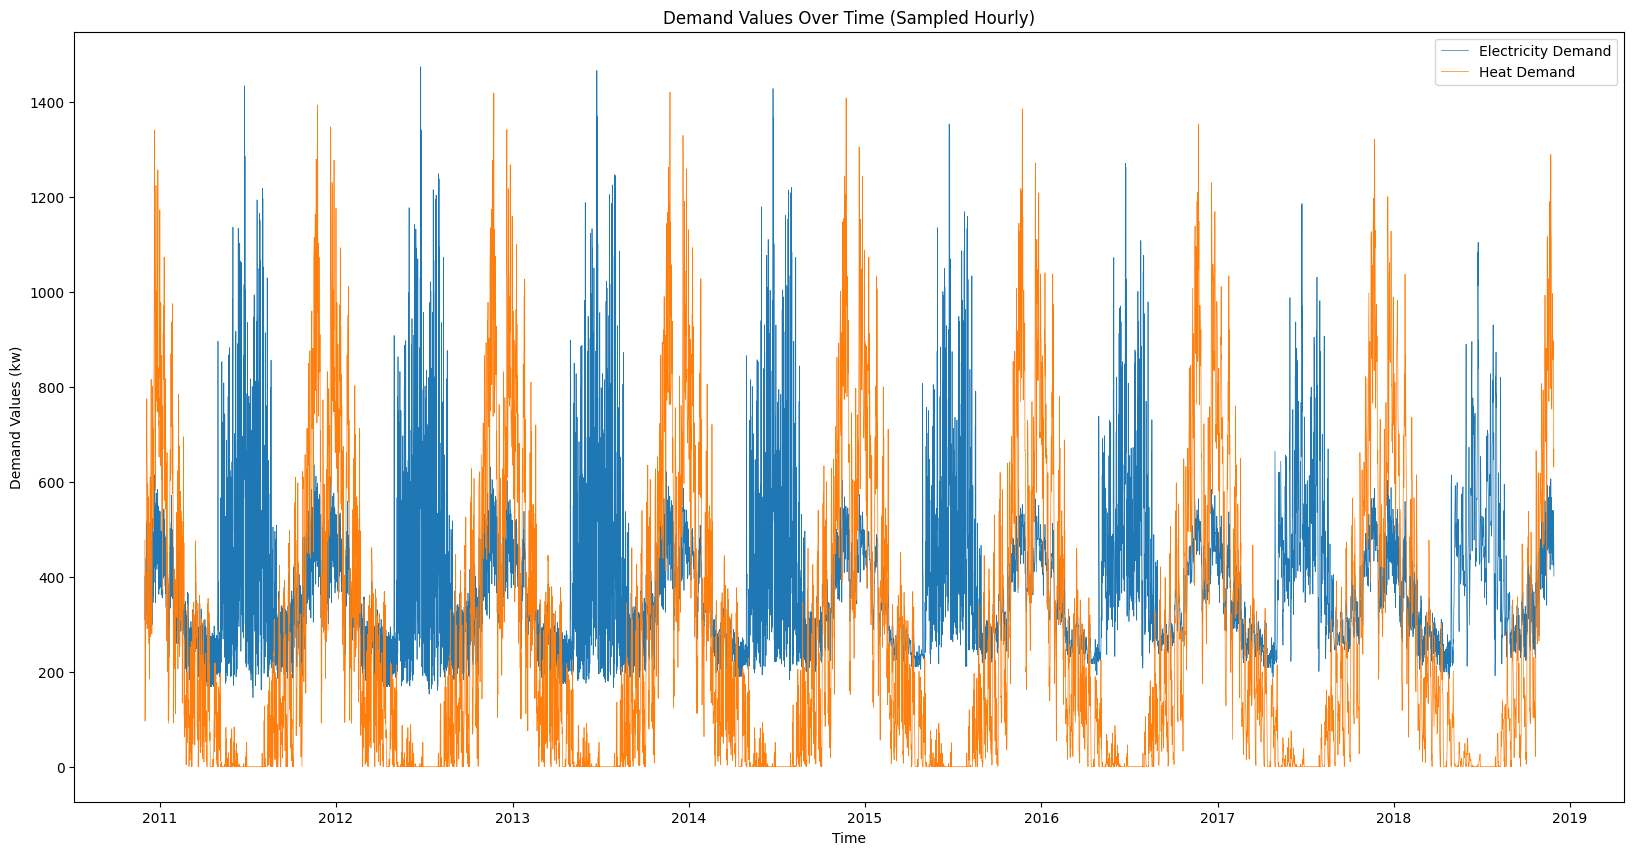

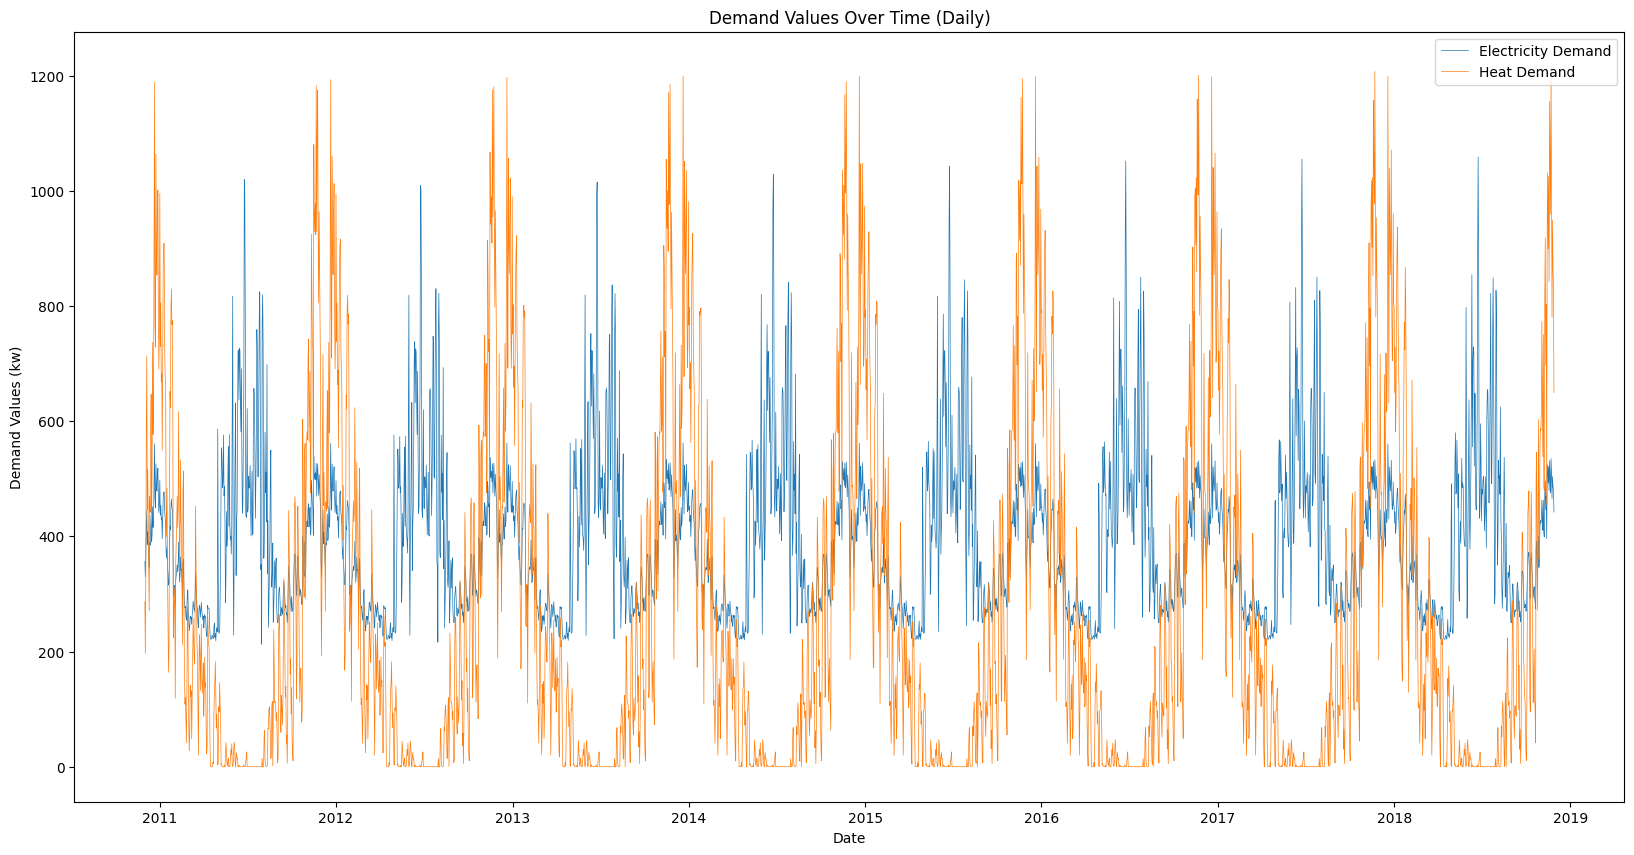

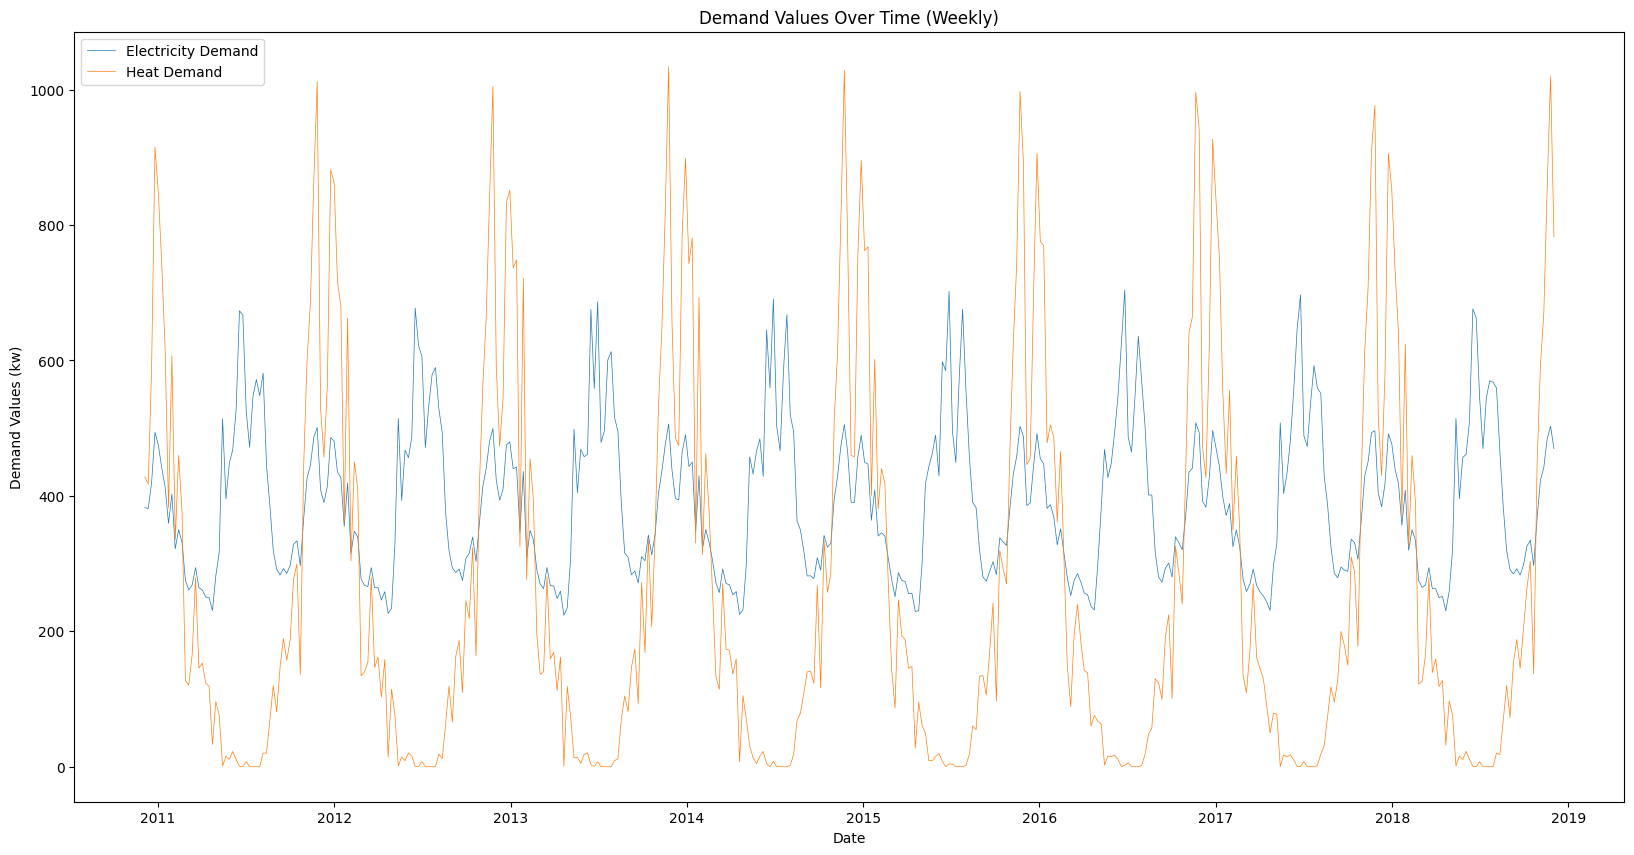

In [ ]:
# Lấy mẫu dữ liệu: mỗi 12 giờ lấy 1 điểm
sampled_data = dataFrame.resample('12H').mean()

# Vẽ đồ thị theo giờ
plt.figure(figsize=(20, 10))
plt.plot(sampled_data.index, sampled_data['electricity_demand_values[kw]'], label='Electricity Demand', linewidth=0.5)
plt.plot(sampled_data.index, sampled_data['heat_demand_values[kw]'], label='Heat Demand', linewidth=0.5)
plt.title('Demand Values Over Time (Sampled Hourly)')
plt.xlabel('Time')
plt.ylabel('Demand Values (kw)')
plt.legend()
plt.show()

# Vẽ đồ thị theo ngày
daily_data = dataFrame.resample('D').mean()
plt.figure(figsize=(20, 10))
plt.plot(daily_data.index, daily_data['electricity_demand_values[kw]'], label='Electricity Demand', linewidth=0.5)
plt.plot(daily_data.index, daily_data['heat_demand_values[kw]'], label='Heat Demand', linewidth=0.5)
plt.title('Demand Values Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Demand Values (kw)')
plt.legend()
plt.show()

# Vẽ đồ thị theo tuần
weekly_data = dataFrame.resample('W').mean()
plt.figure(figsize=(20, 10))
plt.plot(weekly_data.index, weekly_data['electricity_demand_values[kw]'], label='Electricity Demand', linewidth=0.5)
plt.plot(weekly_data.index, weekly_data['heat_demand_values[kw]'], label='Heat Demand', linewidth=0.5)
plt.title('Demand Values Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Demand Values (kw)')
plt.legend()
plt.show()

In [ ]:
dataFrame.isna().sum()

air_pressure[mmHg]                 146
air_temperature[degree celcius]    177
relative_humidity[%]               177
wind_speed[M/S]                    955
solar_irridiation[W/m²]              0
electricity_demand_values[kw]        7
heat_demand_values[kw]               7
dtype: int64

In [ ]:
imputer = SimpleImputer(missing_values=np.nan)
dataFrame.drop(columns=['Time'], inplace=True)
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['electricity_demand_values[kw]', 'heat_demand_values[kw]']] = target_scaler.fit_transform(dataFrame[['electricity_demand_values[kw]', 'heat_demand_values[kw]']].to_numpy())
df_scaled = df_scaled.astype(float)


In [ ]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   air_pressure[mmHg]               70080 non-null  float64
 1   air_temperature[degree celcius]  70080 non-null  float64
 2   relative_humidity[%]             70080 non-null  float64
 3   wind_speed[M/S]                  70080 non-null  float64
 4   solar_irridiation[W/m²]          70080 non-null  float64
 5   electricity_demand_values[kw]    70080 non-null  float64
 6   heat_demand_values[kw]           70080 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'air_pressure[mmHg]'),
  Text(1.5, 0, 'air_temperature[degree celcius]'),
  Text(2.5, 0, 'relative_humidity[%]'),
  Text(3.5, 0, 'wind_speed[M/S]'),
  Text(4.5, 0, 'solar_irridiation[W/m²]'),
  Text(5.5, 0, 'electricity_demand_values[kw]'),
  Text(6.5, 0, 'heat_demand_values[kw]')])

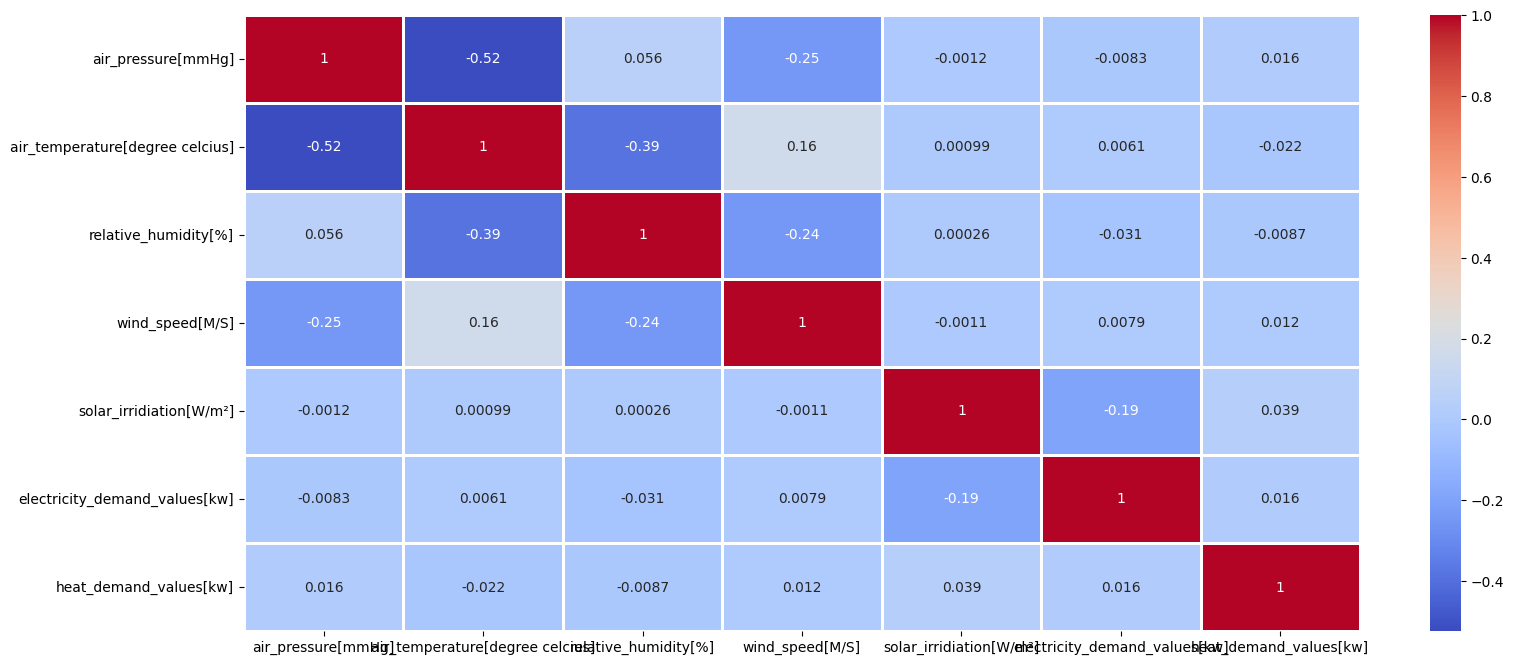

In [ ]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.heatmap(df_scaled.corr(),annot=True,linewidths=1,fmt=".2g",cmap="coolwarm")
plt.xticks(rotation='horizontal')

In [ ]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['electricity_demand_values[kw]', 'heat_demand_values[kw]']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [ ]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

train_size = int(len(df_scaled) * TRAIN_SPLIT)
val_size = int(len(df_scaled) * VAL_SPLIT)
test_size = len(df_scaled) - train_size - val_size

(xData, yData) = singleStepSampler(df_scaled, 20)

X_train = xData[:train_size]
y_train = yData[:train_size]

X_val = xData[train_size:train_size + val_size]
y_val = yData[train_size:train_size + val_size]

X_test = xData[train_size + val_size:]
y_test = yData[train_size + val_size:]

In [ ]:
df_scaled.head(30)

,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],electricity_demand_values[kw],heat_demand_values[kw]
0,0.321951,0.682842,0.843750,0.192308,0.000000,0.119342,0.283121
1,0.314634,0.731369,0.760417,0.269231,0.000000,0.099477,0.309930
2,0.302439,0.826690,0.604167,0.269231,0.000000,0.090764,0.316040
3,0.368293,0.807626,0.604167,0.076923,0.000000,0.097982,0.357005
4,0.392683,0.644714,0.958333,0.115385,0.000000,0.098184,0.360017
5,0.392683,0.672444,0.968750,0.115385,0.000000,0.111240,0.376821
6,0.368293,0.769497,0.614583,0.153846,0.000000,0.151678,0.364763
7,0.446341,0.701906,0.843750,0.076923,0.832618,0.218875,0.377066
8,0.417073,0.644714,1.000000,0.115385,0.497854,0.212044,0.378899
9,0.397561,0.653380,1.000000,0.076923,0.483548,0.151936,0.283394


In [ ]:
X_train.shape


(56064, 20, 7)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
regressor = Sequential()

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True))

regressor.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True))

regressor.add(SimpleRNN(units = 50))

regressor.add(Dense(units = 2,activation='sigmoid'))

regressor.compile(optimizer=Adam(learning_rate=0.001),
                  loss = 'MeanSquaredError',
                  metrics=['MAE'])

early_stopping = EarlyStopping(monitor='loss',
                               patience=3,
                               restore_best_weights=True)

regressor.fit(X_train, y_train,
              validation_data=(X_val,y_val),
              epochs = 20,
              callbacks=[early_stopping])
regressor.summary()

Epoch 1/20
1752/1752 [==============================] - 32s 16ms/step - loss: 0.0032 - MAE: 0.0380 - val_loss: 0.0012 - val_MAE: 0.0251
Epoch 2/20
1752/1752 [==============================] - 28s 16ms/step - loss: 0.0011 - MAE: 0.0234 - val_loss: 9.0834e-04 - val_MAE: 0.0204
Epoch 3/20
1752/1752 [==============================] - 28s 16ms/step - loss: 8.1999e-04 - MAE: 0.0198 - val_loss: 7.0288e-04 - val_MAE: 0.0187
Epoch 4/20
1752/1752 [==============================] - 29s 17ms/step - loss: 6.6607e-04 - MAE: 0.0177 - val_loss: 5.1778e-04 - val_MAE: 0.0154
Epoch 5/20
1752/1752 [==============================] - 28s 16ms/step - loss: 5.8061e-04 - MAE: 0.0163 - val_loss: 4.1229e-04 - val_MAE: 0.0134
Epoch 6/20
1752/1752 [==============================] - 27s 15ms/step - loss: 4.9810e-04 - MAE: 0.0150 - val_loss: 4.8520e-04 - val_MAE: 0.0141
Epoch 7/20
1752/1752 [==============================] - 28s 16ms/step - loss: 4.7469e-04 - MAE: 0.0146 - val_loss: 5.9093e-04 - val_MAE: 0.0153
Epoc

In [ ]:
regressor.save('rnn_model.h5')

NameError: name 'regressor' is not defined

In [ ]:
regressorLSTM = Sequential()

regressorLSTM.add(LSTM(50,
                       return_sequences = True,
                       input_shape = (X_train.shape[1],X_train.shape[2])))
regressorLSTM.add(LSTM(50,
                       return_sequences = False))
regressorLSTM.add(Dense(25))

regressorLSTM.add(Dense(2))


regressorLSTM.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics=['MAE'])

early_stopping = EarlyStopping(monitor='loss',
                               patience=3,
                               restore_best_weights=True)
regressorLSTM.fit(X_train,y_train,
                  validation_data=(X_val,y_val),
                  epochs = 20,
                  callbacks=[early_stopping])
regressorLSTM.summary()

Epoch 1/20
1752/1752 [==============================] - 26s 14ms/step - loss: 0.0026 - MAE: 0.0329 - val_loss: 6.8190e-04 - val_MAE: 0.0188
Epoch 2/20
1752/1752 [==============================] - 23s 13ms/step - loss: 5.8419e-04 - MAE: 0.0174 - val_loss: 6.1782e-04 - val_MAE: 0.0173
Epoch 3/20
1752/1752 [==============================] - 22s 13ms/step - loss: 5.1553e-04 - MAE: 0.0161 - val_loss: 5.4349e-04 - val_MAE: 0.0163
Epoch 4/20
1752/1752 [==============================] - 22s 13ms/step - loss: 4.6805e-04 - MAE: 0.0152 - val_loss: 5.3710e-04 - val_MAE: 0.0162
Epoch 5/20
1752/1752 [==============================] - 22s 13ms/step - loss: 4.3725e-04 - MAE: 0.0146 - val_loss: 5.6326e-04 - val_MAE: 0.0163
Epoch 6/20
1752/1752 [==============================] - 23s 13ms/step - loss: 4.1233e-04 - MAE: 0.0141 - val_loss: 5.5851e-04 - val_MAE: 0.0157
Epoch 7/20
1752/1752 [==============================] - 22s 13ms/step - loss: 3.9529e-04 - MAE: 0.0137 - val_loss: 7.4822e-04 - val_MAE: 0.0

In [ ]:
regressorLSTM.save('lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
regressorGRU = Sequential()

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],X_train.shape[2]),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,return_sequences=True,activation='tanh'))

regressorGRU.add(GRU(units=50,return_sequences=True,activation='tanh'))

regressorGRU.add(GRU(units=50,activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=2,activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer = 'adam',
                     loss = 'mean_squared_error',
                     metrics=['MAE']
                      )
early_stopping = EarlyStopping(monitor='loss',
                               patience=3,
                               restore_best_weights=True)
# Fitting the data
regressorGRU.fit(X_train,y_train,
                 validation_data=(X_val,y_val),
                 epochs=20,
                 callbacks=[early_stopping])
regressorGRU.summary()

Epoch 1/20
1752/1752 [==============================] - 50s 26ms/step - loss: 0.0024 - MAE: 0.0315 - val_loss: 7.7563e-04 - val_MAE: 0.0189
Epoch 2/20
1752/1752 [==============================] - 64s 36ms/step - loss: 8.1234e-04 - MAE: 0.0195 - val_loss: 6.7223e-04 - val_MAE: 0.0165
Epoch 3/20
1752/1752 [==============================] - 44s 25ms/step - loss: 6.4416e-04 - MAE: 0.0172 - val_loss: 5.5436e-04 - val_MAE: 0.0153
Epoch 4/20
1752/1752 [==============================] - 44s 25ms/step - loss: 5.6916e-04 - MAE: 0.0160 - val_loss: 4.6564e-04 - val_MAE: 0.0139
Epoch 5/20
1752/1752 [==============================] - 46s 26ms/step - loss: 5.0104e-04 - MAE: 0.0148 - val_loss: 4.0569e-04 - val_MAE: 0.0127
Epoch 6/20
1752/1752 [==============================] - 44s 25ms/step - loss: 4.5451e-04 - MAE: 0.0139 - val_loss: 4.5847e-04 - val_MAE: 0.0134
Epoch 7/20
1752/1752 [==============================] - 41s 24ms/step - loss: 4.2295e-04 - MAE: 0.0133 - val_loss: 7.5854e-04 - val_MAE: 0.0

In [ ]:
regressorGRU.save('gru_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
regressor = load_model('/content/rnn_model.h5')
regressorLSTM = load_model('/content/lstm_model.h5')
regressorGRU = load_model('/content/gru_model.h5')

In [ ]:
y_pred_rnn = regressor.predict(X_test)
y_pred_lstm = regressorLSTM.predict(X_test)
y_pred_gru = regressorGRU.predict(X_test)

219/219 [==============================] - 4s 11ms/step


In [ ]:
y_test_original = target_scaler.inverse_transform(y_test)
y_pred_rnn_original = target_scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_original = target_scaler.inverse_transform(y_pred_lstm)
y_pred_gru_original = target_scaler.inverse_transform(y_pred_gru)


In [ ]:
y_test_original

array([[228.6388036, 185.8930671],
       [228.3156736, 190.8530515],
       [245.0526578, 218.0854295],
       ...,
       [365.0094907, 571.4651299],
       [396.9664939, 583.703242 ],
       [489.8831877, 581.8464277]])

In [ ]:
y_pred_gru_original

array([[223.6188 , 159.44188],
       [214.76196, 152.96196],
       [229.49965, 176.54683],
       ...,
       [352.16177, 599.1369 ],
       [364.26096, 576.0857 ],
       [467.39868, 599.54895]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Tính toán các chỉ số đánh giá cho electricity_demand_values[kw]
mae_rnn_electricity = mean_absolute_error(y_test_original[:, 0], y_pred_rnn_original[:, 0])
mse_rnn_electricity = mean_squared_error(y_test_original[:, 0], y_pred_rnn_original[:, 0])
r2_rnn_electricity = r2_score(y_test_original[:, 0], y_pred_rnn_original[:, 0])
mape_rnn_electricity = mean_absolute_percentage_error(y_test_original[:, 0], y_pred_rnn_original[:, 0])

mae_lstm_electricity = mean_absolute_error(y_test_original[:, 0], y_pred_lstm_original[:, 0])
mse_lstm_electricity = mean_squared_error(y_test_original[:, 0], y_pred_lstm_original[:, 0])
r2_lstm_electricity = r2_score(y_test_original[:, 0], y_pred_lstm_original[:, 0])
mape_lstm_electricity = mean_absolute_percentage_error(y_test_original[:, 0], y_pred_lstm_original[:, 0])

mae_gru_electricity = mean_absolute_error(y_test_original[:, 0], y_pred_gru_original[:, 0])
mse_gru_electricity = mean_squared_error(y_test_original[:, 0], y_pred_gru_original[:, 0])
r2_gru_electricity = r2_score(y_test_original[:, 0], y_pred_gru_original[:, 0])
mape_gru_electricity = mean_absolute_percentage_error(y_test_original[:, 0], y_pred_gru_original[:, 0])

# Tính toán các chỉ số đánh giá cho heat_demand_values[kw]
mae_rnn_heat = mean_absolute_error(y_test_original[:, 1], y_pred_rnn_original[:, 1])
mse_rnn_heat = mean_squared_error(y_test_original[:, 1], y_pred_rnn_original[:, 1])
r2_rnn_heat = r2_score(y_test_original[:, 1], y_pred_rnn_original[:, 1])
mape_rnn_heat = mean_absolute_percentage_error(y_test_original[:, 1], y_pred_rnn_original[:, 1])

mae_lstm_heat = mean_absolute_error(y_test_original[:, 1], y_pred_lstm_original[:, 1])
mse_lstm_heat = mean_squared_error(y_test_original[:, 1], y_pred_lstm_original[:, 1])
r2_lstm_heat = r2_score(y_test_original[:, 1], y_pred_lstm_original[:, 1])
mape_lstm_heat = mean_absolute_percentage_error(y_test_original[:, 1], y_pred_lstm_original[:, 1])

mae_gru_heat = mean_absolute_error(y_test_original[:, 1], y_pred_gru_original[:, 1])
mse_gru_heat = mean_squared_error(y_test_original[:, 1], y_pred_gru_original[:, 1])
r2_gru_heat = r2_score(y_test_original[:, 1], y_pred_gru_original[:, 1])
mape_gru_heat = mean_absolute_percentage_error(y_test_original[:, 1], y_pred_gru_original[:, 1])

# Hiển thị kết quả
print("SimpleRNN - Electricity Demand:")
print(f"   MAE: {mae_rnn_electricity:.4f}")
print(f"   MSE: {mse_rnn_electricity:.4f}")
print(f"   R-squared Score: {r2_rnn_electricity:.4f}")
print(f"   MAPE: {mape_rnn_electricity:.4f}%")

print("SimpleRNN - Heat Demand:")
print(f"   MAE: {mae_rnn_heat:.4f}")
print(f"   MSE: {mse_rnn_heat:.4f}")
print(f"   R-squared Score: {r2_rnn_heat:.4f}")
print(f"   MAPE: {mape_rnn_heat:.4f}%")

print("LSTM - Electricity Demand:")
print(f"   MAE: {mae_lstm_electricity:.4f}")
print(f"   MSE: {mse_lstm_electricity:.4f}")
print(f"   R-squared Score: {r2_lstm_electricity:.4f}")
print(f"   MAPE: {mape_lstm_electricity:.4f}%")

print("LSTM - Heat Demand:")
print(f"   MAE: {mae_lstm_heat:.4f}")
print(f"   MSE: {mse_lstm_heat:.4f}")
print(f"   R-squared Score: {r2_lstm_heat:.4f}")
print(f"   MAPE: {mape_lstm_heat:.4f}%")

print("GRU - Electricity Demand:")
print(f"   MAE: {mae_gru_electricity:.4f}")
print(f"   MSE: {mse_gru_electricity:.4f}")
print(f"   R-squared Score: {r2_gru_electricity:.4f}")
print(f"   MAPE: {mape_gru_electricity:.4f}%")

print("GRU - Heat Demand:")
print(f"   MAE: {mae_gru_heat:.4f}")
print(f"   MSE: {mse_gru_heat:.4f}")
print(f"   R-squared Score: {r2_gru_heat:.4f}")
print(f"   MAPE: {mape_gru_heat:.4f}%")

SimpleRNN - Electricity Demand:
   MAE: 13.8461
   MSE: 432.8507
   R-squared Score: 0.9935
   MAPE: 0.0396%
SimpleRNN - Heat Demand:
   MAE: 12.6776
   MSE: 394.9484
   R-squared Score: 0.9945
   MAPE: 7505175796589393.0000%
LSTM - Electricity Demand:
   MAE: 16.1161
   MSE: 720.9431
   R-squared Score: 0.9892
   MAPE: 0.0448%
LSTM - Heat Demand:
   MAE: 13.7404
   MSE: 406.9963
   R-squared Score: 0.9944
   MAPE: 14380619635068490.0000%
GRU - Electricity Demand:
   MAE: 16.8617
   MSE: 651.7096
   R-squared Score: 0.9903
   MAPE: 0.0436%
GRU - Heat Demand:
   MAE: 10.4901
   MSE: 322.8267
   R-squared Score: 0.9955
   MAPE: 2019364221832280.5000%


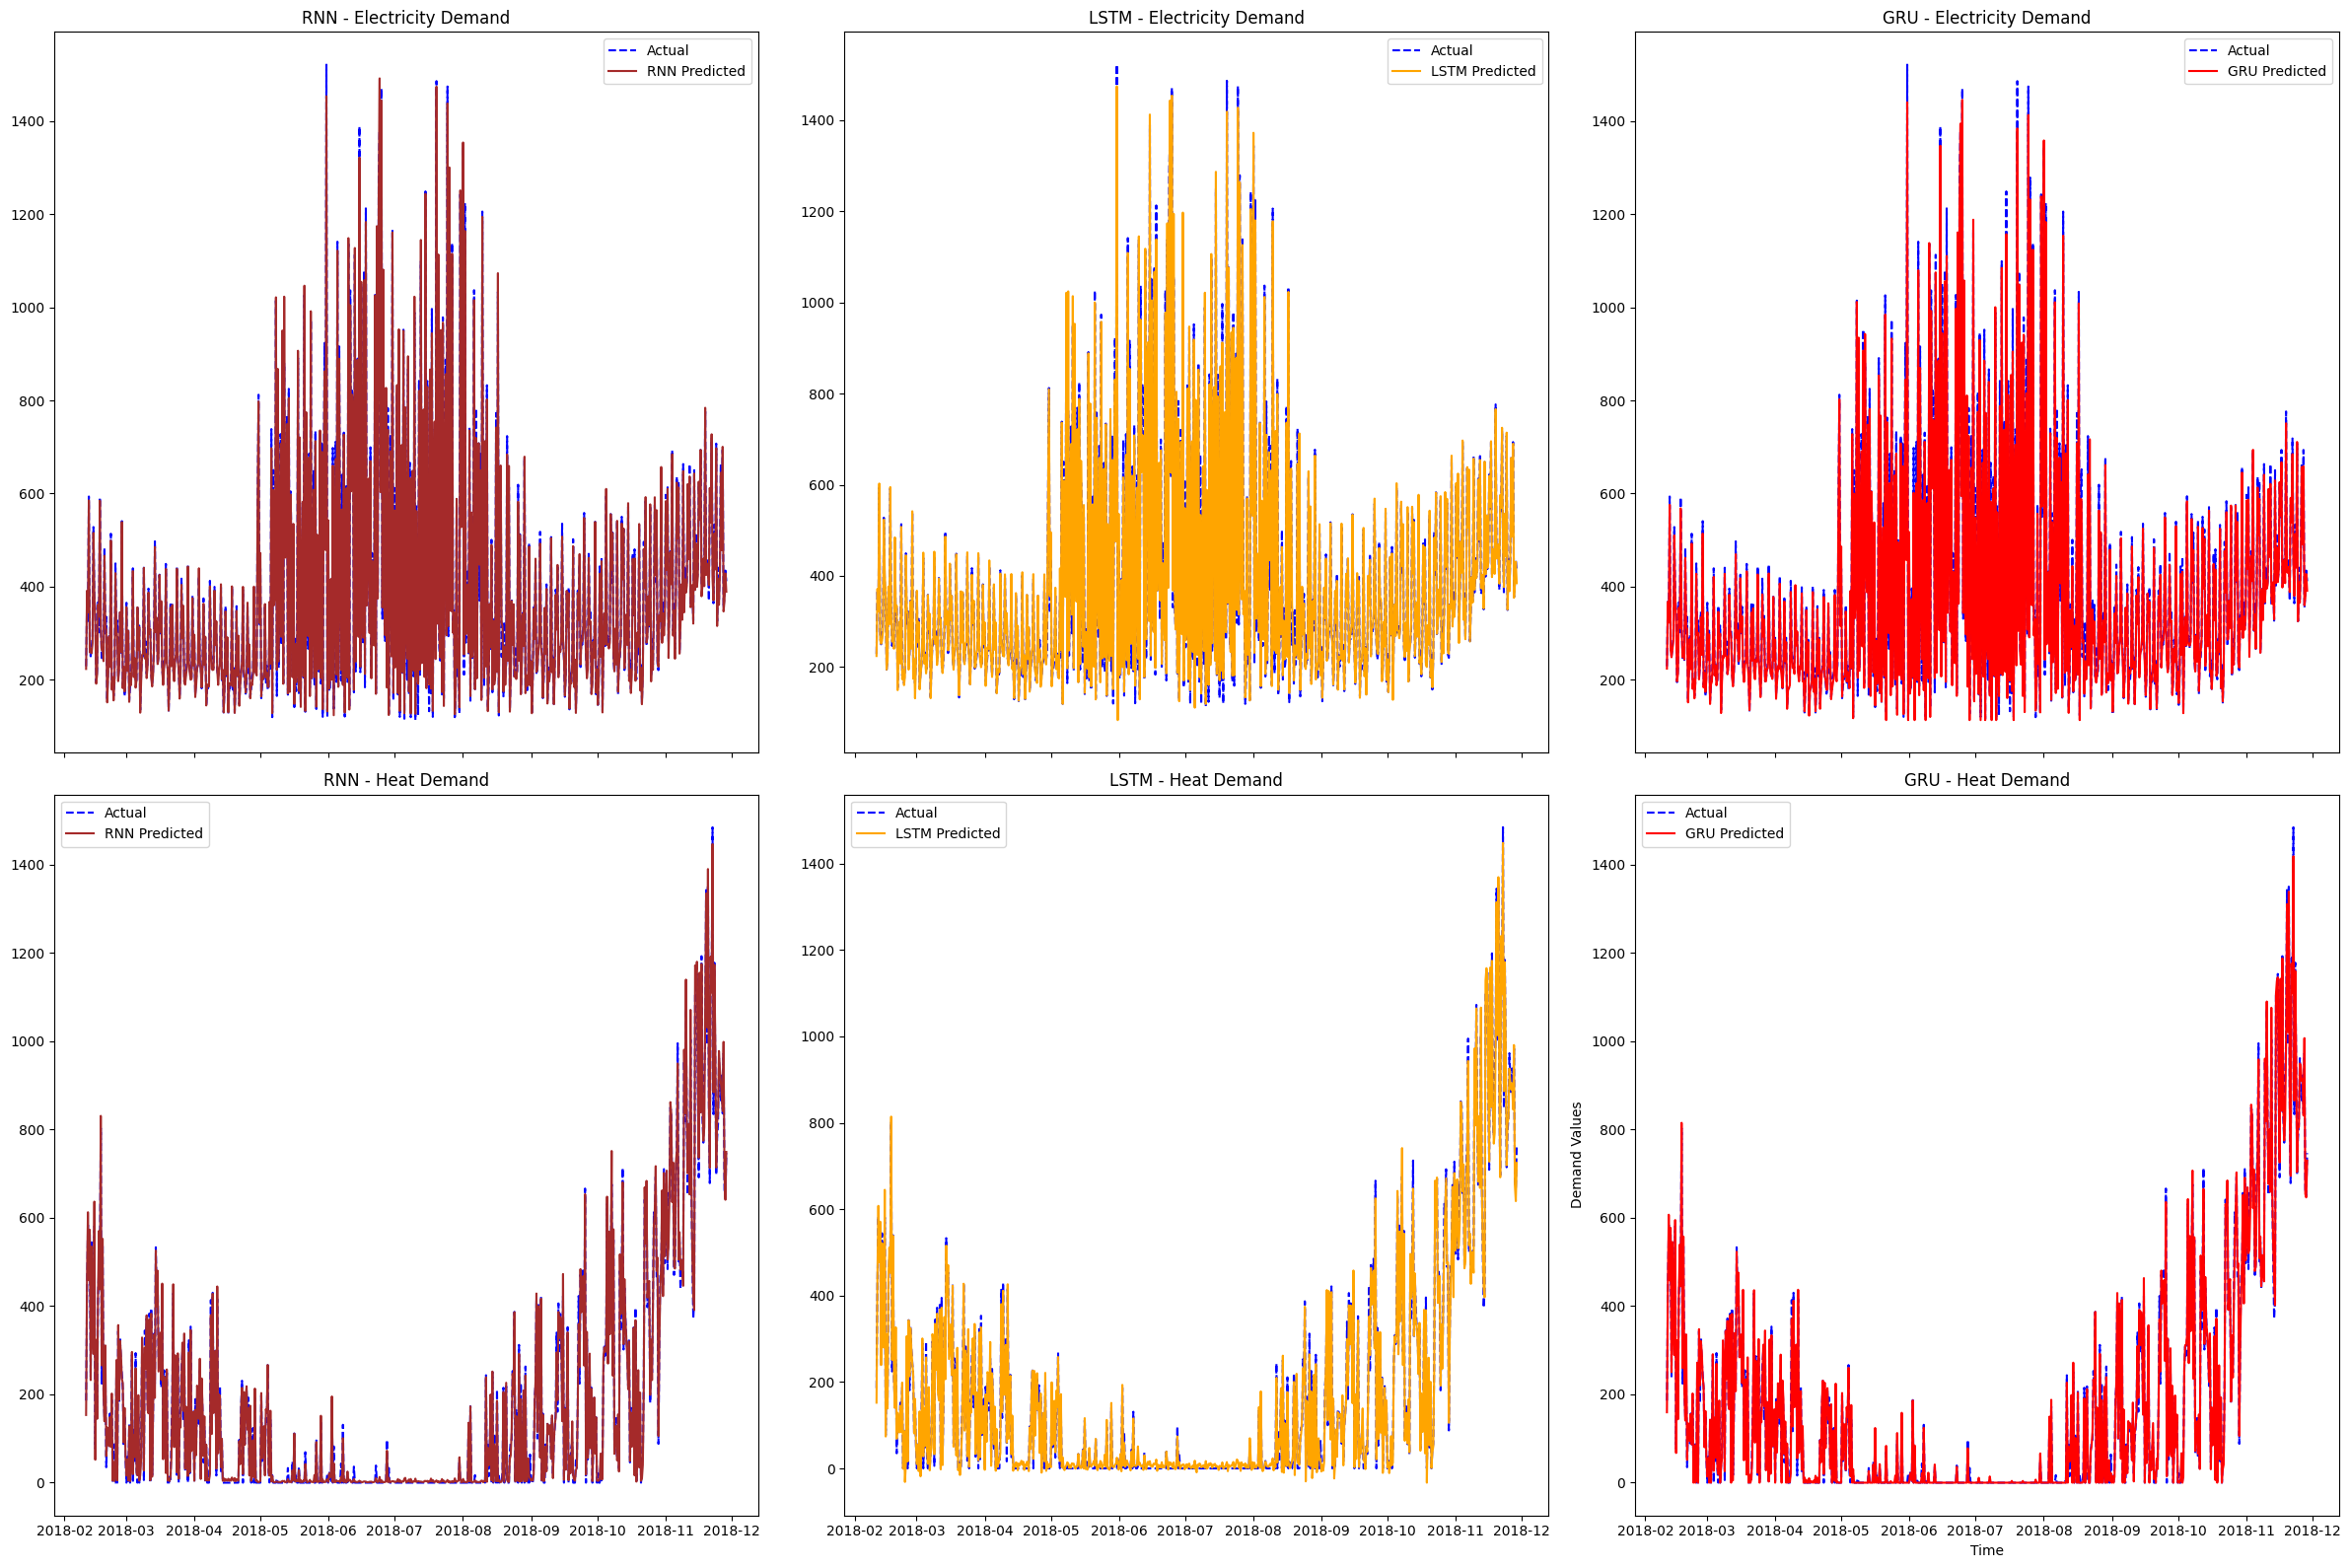

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24, 16), sharex=True)

# Electricity Demand Prediction
axs[0, 0].plot(dataFrame.index[-len(y_test_original)::10], y_test_original[::10, 0], label="Actual", color="b", linestyle='dashed')
axs[0, 0].plot(dataFrame.index[-len(y_pred_rnn)::10], y_pred_rnn_original[::10, 0], label="RNN Predicted", color="brown")
axs[0, 0].set_title("RNN - Electricity Demand")
axs[0, 0].legend()

axs[0, 1].plot(dataFrame.index[-len(y_test_original)::10], y_test_original[::10, 0], label="Actual", color="b", linestyle='dashed')
axs[0, 1].plot(dataFrame.index[-len(y_pred_lstm)::10], y_pred_lstm_original[::10, 0], label="LSTM Predicted", color="orange")
axs[0, 1].set_title("LSTM - Electricity Demand")
axs[0, 1].legend()

axs[0, 2].plot(dataFrame.index[-len(y_test_original)::10], y_test_original[::10, 0], label="Actual", color="b", linestyle='dashed')
axs[0, 2].plot(dataFrame.index[-len(y_pred_gru)::10], y_pred_gru_original[::10, 0], label="GRU Predicted", color="red")
axs[0, 2].set_title("GRU - Electricity Demand")
axs[0, 2].legend()

# Heat Demand Prediction
axs[1, 0].plot(dataFrame.index[-len(y_test_original)::10], y_test_original[::10, 1], label="Actual", color="b", linestyle='dashed')
axs[1, 0].plot(dataFrame.index[-len(y_pred_rnn)::10], y_pred_rnn_original[::10, 1], label="RNN Predicted", color="brown")
axs[1, 0].set_title("RNN - Heat Demand")
axs[1, 0].legend()

axs[1, 1].plot(dataFrame.index[-len(y_test_original)::10], y_test_original[::10, 1], label="Actual", color="b", linestyle='dashed')
axs[1, 1].plot(dataFrame.index[-len(y_pred_lstm)::10], y_pred_lstm_original[::10, 1], label="LSTM Predicted", color="orange")
axs[1, 1].set_title("LSTM - Heat Demand")
axs[1, 1].legend()

axs[1, 2].plot(dataFrame.index[-len(y_test_original)::10], y_test_original[::10, 1], label="Actual", color="b", linestyle='dashed')
axs[1, 2].plot(dataFrame.index[-len(y_pred_gru)::10], y_pred_gru_original[::10, 1], label="GRU Predicted", color="red")
axs[1, 2].set_title("GRU - Heat Demand")
axs[1, 2].legend()

plt.xlabel("Time")
plt.ylabel("Demand Values")
plt.tight_layout()
plt.show()

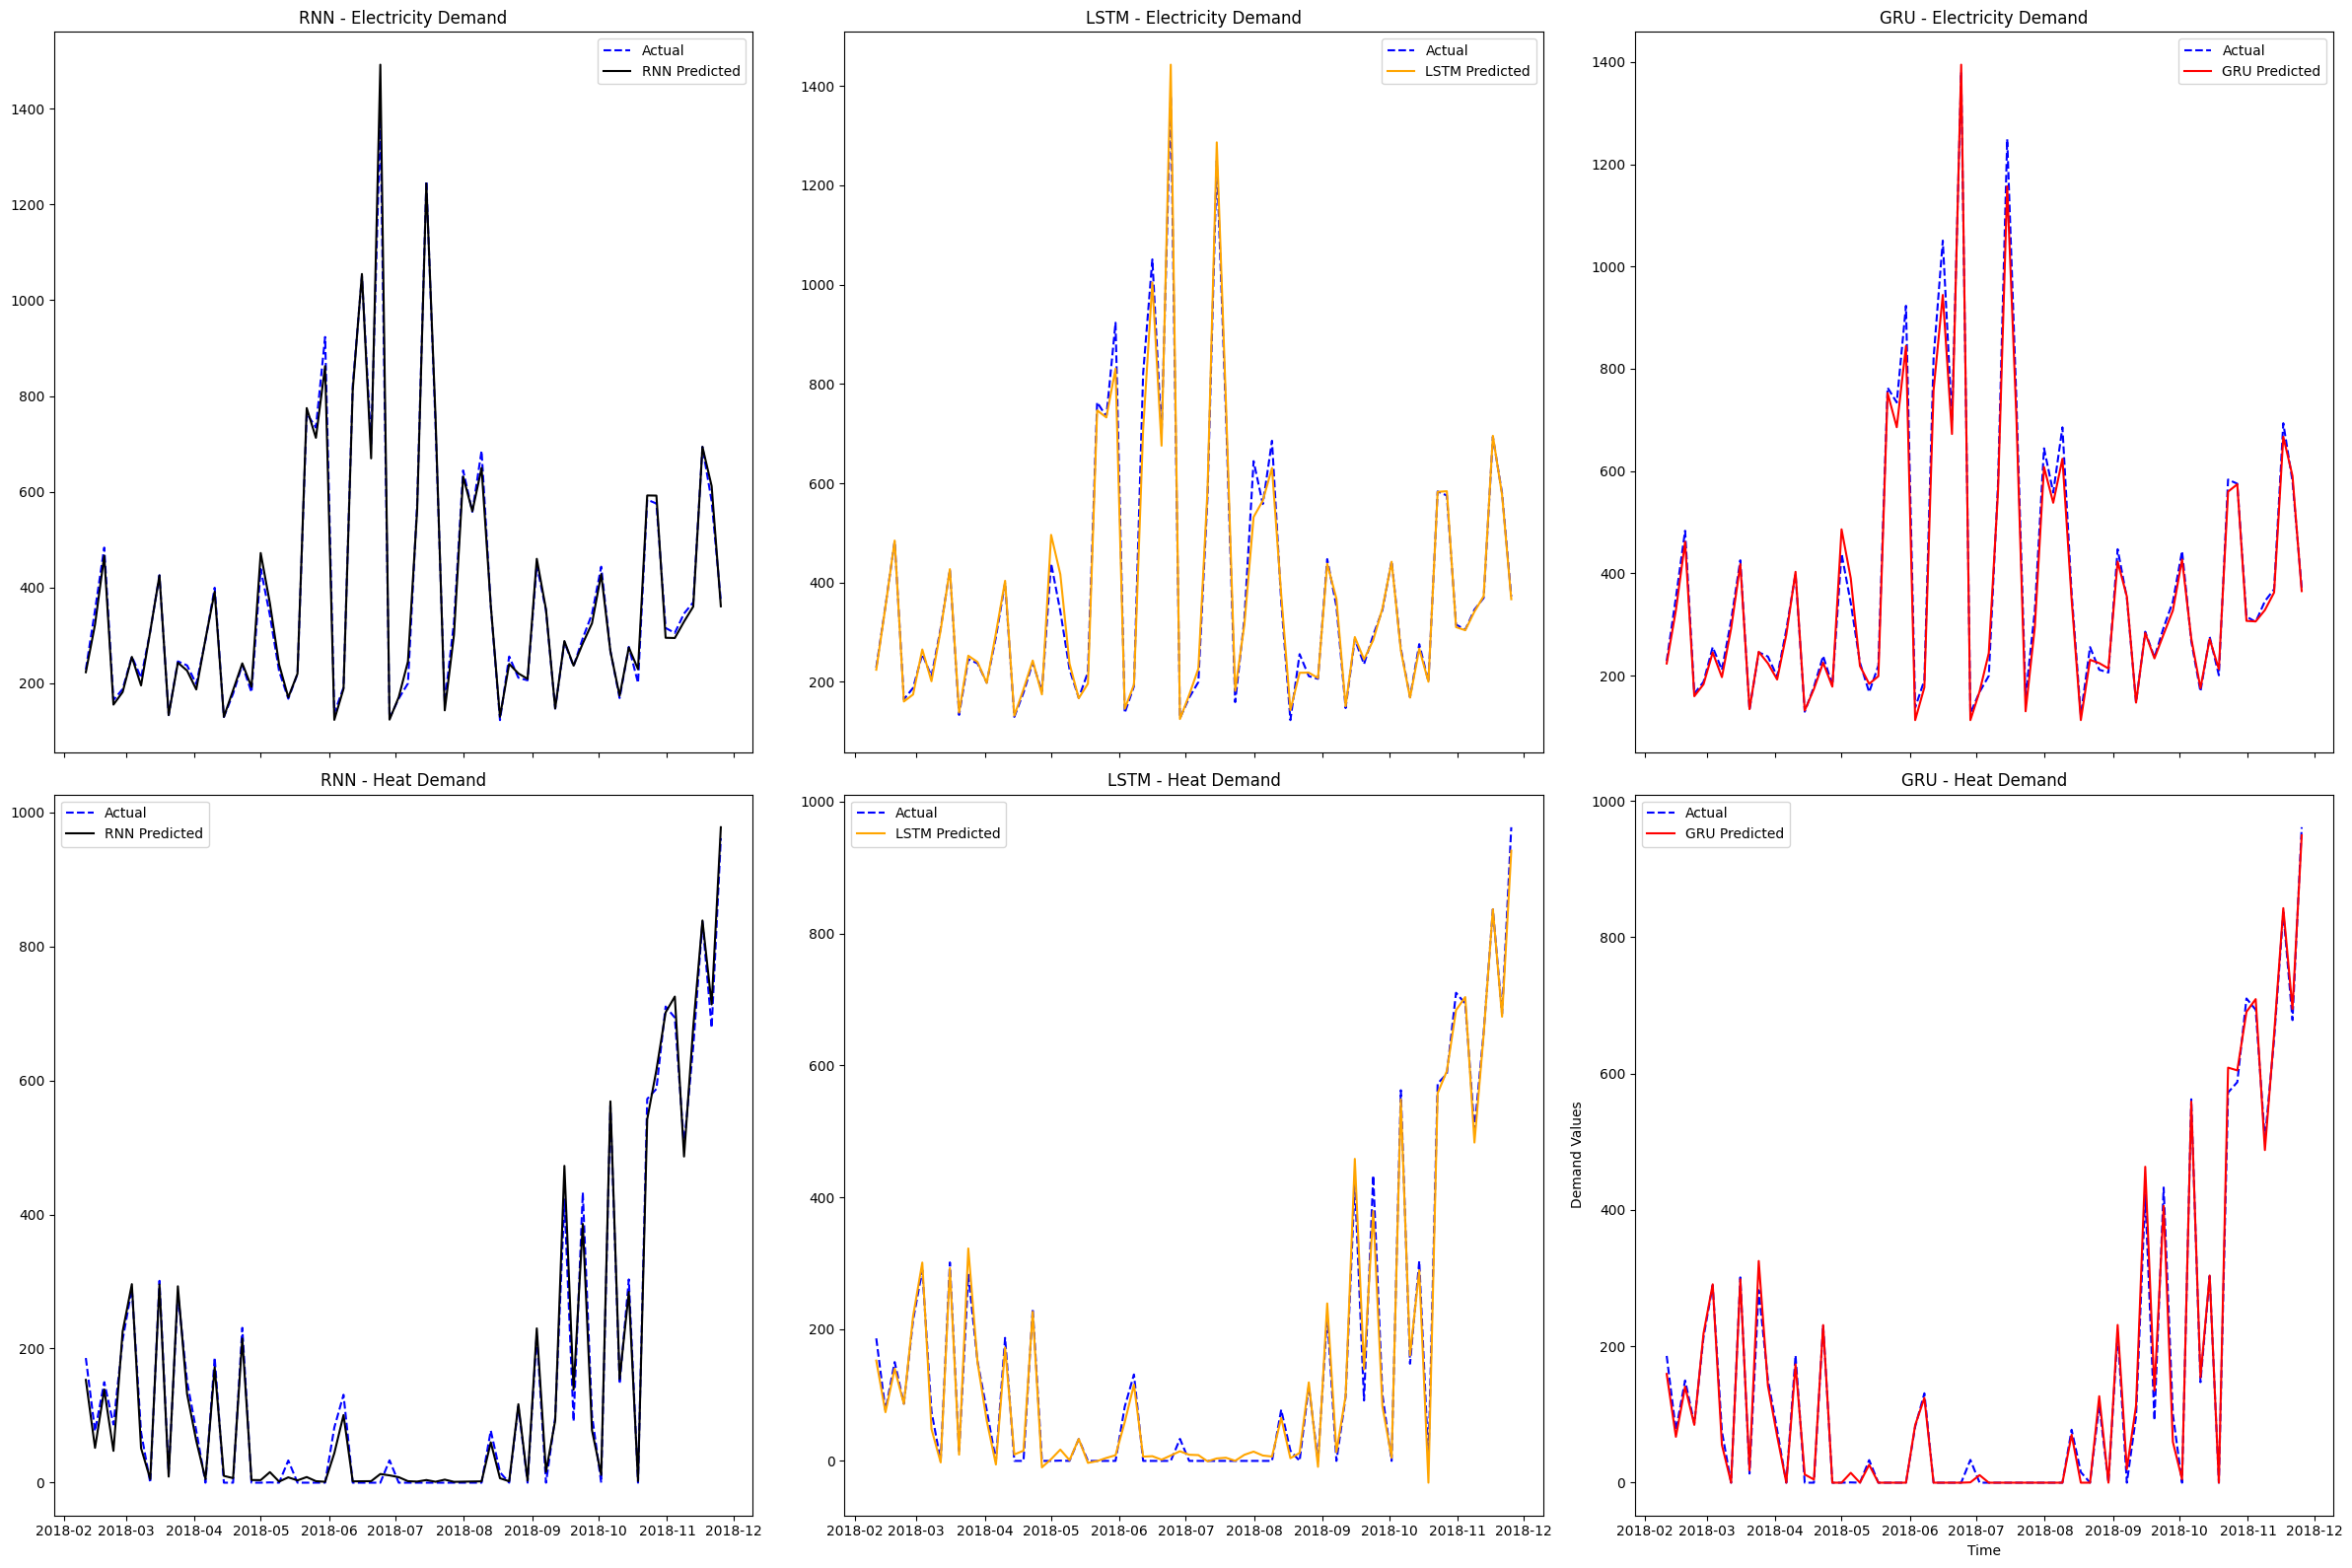

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24, 16), sharex=True)

# Electricity Demand Prediction
axs[0, 0].plot(dataFrame.index[-len(y_test_original):][::100], y_test_original[::100, 0], label="Actual", color="b", linestyle='dashed')
axs[0, 0].plot(dataFrame.index[-len(y_pred_rnn):][::100], y_pred_rnn_original[::100, 0], label="RNN Predicted", color="black")
axs[0, 0].set_title("RNN - Electricity Demand")
axs[0, 0].legend()

axs[0, 1].plot(dataFrame.index[-len(y_test_original):][::100], y_test_original[::100, 0], label="Actual", color="b", linestyle='dashed')
axs[0, 1].plot(dataFrame.index[-len(y_pred_lstm):][::100], y_pred_lstm_original[::100, 0], label="LSTM Predicted", color="orange")
axs[0, 1].set_title("LSTM - Electricity Demand")
axs[0, 1].legend()

axs[0, 2].plot(dataFrame.index[-len(y_test_original):][::100], y_test_original[::100, 0], label="Actual", color="b", linestyle='dashed')
axs[0, 2].plot(dataFrame.index[-len(y_pred_gru):][::100], y_pred_gru_original[::100, 0], label="GRU Predicted", color="red")
axs[0, 2].set_title("GRU - Electricity Demand")
axs[0, 2].legend()

# Heat Demand Prediction
axs[1, 0].plot(dataFrame.index[-len(y_test_original):][::100], y_test_original[::100, 1], label="Actual", color="b", linestyle='dashed')
axs[1, 0].plot(dataFrame.index[-len(y_pred_rnn):][::100], y_pred_rnn_original[::100, 1], label="RNN Predicted", color="black")
axs[1, 0].set_title("RNN - Heat Demand")
axs[1, 0].legend()

axs[1, 1].plot(dataFrame.index[-len(y_test_original):][::100], y_test_original[::100, 1], label="Actual", color="b", linestyle='dashed')
axs[1, 1].plot(dataFrame.index[-len(y_pred_lstm):][::100], y_pred_lstm_original[::100, 1], label="LSTM Predicted", color="orange")
axs[1, 1].set_title("LSTM - Heat Demand")
axs[1, 1].legend()

axs[1, 2].plot(dataFrame.index[-len(y_test_original):][::100], y_test_original[::100, 1], label="Actual", color="b", linestyle='dashed')
axs[1, 2].plot(dataFrame.index[-len(y_pred_gru):][::100], y_pred_gru_original[::100, 1], label="GRU Predicted", color="red")
axs[1, 2].set_title("GRU - Heat Demand")
axs[1, 2].legend()

plt.xlabel("Time")
plt.ylabel("Demand Values")
plt.tight_layout()
plt.show()